In [6]:
import pandas as pd
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io import  gtfs_importer
from quetzal.model import stepmodel, model

In [7]:
training_folder = '../../'

In [8]:
sm = stepmodel.read_zip(training_folder + 'model/preparation/road.zip')

read_hdf: : 100%|██████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.98it/s]


# Networkcaster
à faire sur un réseau propre, avant l'agrégation

In [9]:
sm.integrity_test_all(errors='raise', verbose=False)

10006it [00:00, 10466.22it/s]
10006it [00:03, 2523.63it/s]


## rail

In [10]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|██████████████████████████████████████████████████████████| 58470/58470 [00:00<00:00, 112010.97it/s]


## road

In [11]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [12]:
len(sm.road_nodes), len(sm.road_links)

(10006, 27250)

In [13]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

7227121181012008100%|████████████████████████████████████████████████████████████████| 341/341 [00:37<00:00,  6.03it/s]
road_paths : 4529it [00:04, 1044.51it/s]                                                                               


## both road and rail

In [14]:
both = road.copy()
both.links = pd.concat([road.links, rail.links]) 

In [15]:
both.analysis_lines(line_columns='all')

# to_zip

In [16]:
both.to_zip(training_folder + 'model/preparation/road_model.zip' )  

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 33/33 [00:03<00:00, 10.84it/s]


could not save attribute: missing_nodes
could not save attribute: missing_road_nodes
could not save attribute: networkcaster


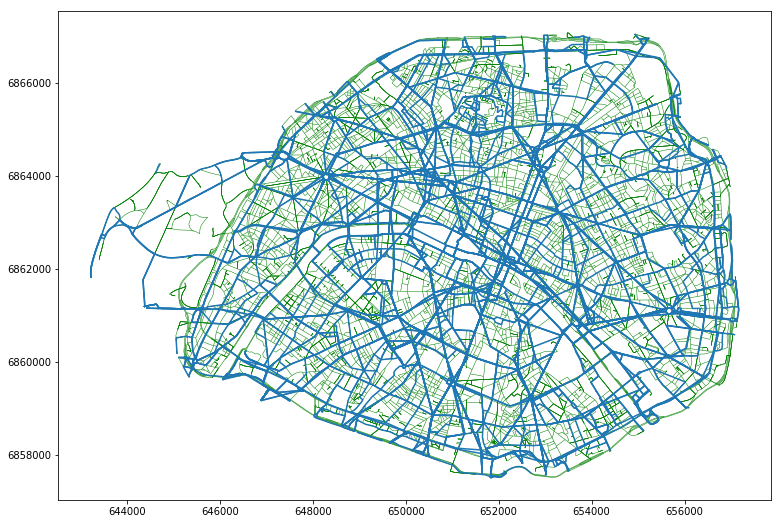

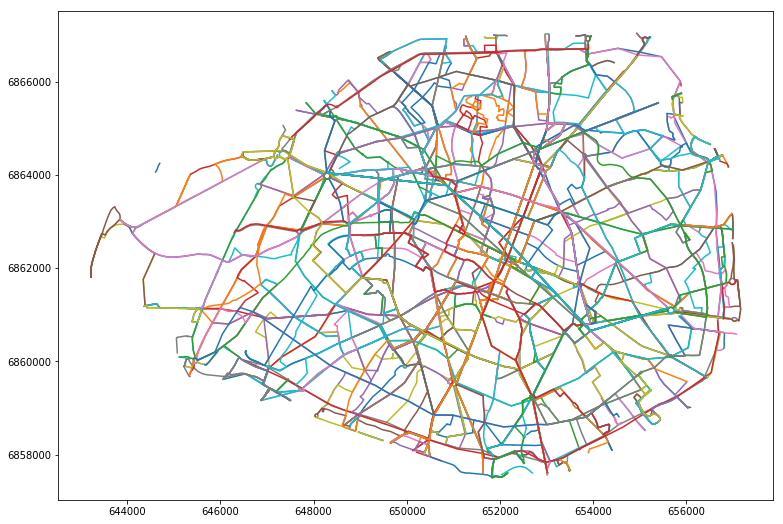

In [17]:
%matplotlib inline
both.plot('links', ax=both.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5))
both.plot('lines', figsize=[16, 9], column='route_color')

# networkcaster_monitoring

In [19]:
both.to_json(
    training_folder + 'model/latest'
)  

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 33/33 [00:44<00:00,  1.34s/it]


could not save attribute: missing_nodes
could not save attribute: missing_road_nodes
could not save attribute: networkcaster


In [20]:
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

# summary
(lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int)

Deprecated: replaced by analysis_lines


link_straight_length    1387
straight_length         1094
length                  1588
dtype: int32

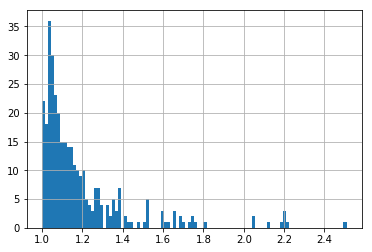

In [21]:
% matplotlib inline
ax = lines['length_ratio'].hist(bins=100)